In [1]:
# !pip -q install pandas openpyxl matplotlib transformers "numpy<2" torch==2.3.0 nltk squarify spacy vaderSentiment

In [1]:
# runtime ~45s

import pandas as pd
import numpy as np

# Define file paths
filepath1 = r"Raw Web Reviews 2023-2024.xlsx"
filepath2 = r"Combined Survey+Web review.xlsx"

# Read the Excel files into DataFrames
raw_df = pd.read_excel(filepath1, dtype=str)
combined_df = pd.read_excel(filepath2, dtype=str)

# raw_df.count()                                # 48,404 records
# raw_df['Verbatim Text'].nunique()             # 41,365 unique text reviews
# raw_df['Product Name'].nunique()              # 185 unique products
# raw_df['Product Number (SKU)'].nunique()      # 185 unique product number SKUs
# raw_df['Review Source'].nunique()             # 10 unique review source
# raw_df['Ink Supply Type'].nunique()           # 2 Ink Supply Type; IIC (Ink-In-Cap) & IPH (Ink Per Head)

combined_df.head(3)

,Survey ID,Product Name,Print Customer Region,LTR,Overall Satisfaction,Setup Success,Finding the right printer,Buying the printer,Setting up the printer,Using the printer,...,Printer Purchase Location,Printer Purchase Location (Other),HP+ Benefits Awareness Timing,HP+ Requirements Awareness Timing,Combined Text,predicted,predicted_probabilities,Ink Supply Type,Ink cartridge number,length
0,251212488,HP 62 Tri-color Original Ink Cartridge,US,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,product great,Ink/toner - General satisfied,0.970894889234059,IPH,NaN,13
1,252503868,HP 62XL High Yield Black Original Ink Cartridge,US,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,item black cartridge divert time work fine,Does not print black,0.772510356417799,IPH,NaN,42
2,57619273,HP 951XL High Yield Magenta Original Ink Cartr...,US,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,text easy understand,others,NaN,IIC,NaN,20


In [3]:
import re 

# Get unique lower text data from Verbatim Text (Translated) & Verbatim Text
# *** potential loss of nuance from global lowercase
raw_df['text'] = raw_df['Verbatim Text (Translated)'].replace('', np.nan).fillna(raw_df['Verbatim Text']).str.lower()
unique_df = raw_df[['Product Name', 'Star Rating', 'Product Number (SKU)', 'Review Source', 'text', 'Ink Supply Type']].drop_duplicates(keep=False).reset_index(drop=True)

# Create proxy sentiment based on 'Star Rating'
unique_df['sentiment'] = unique_df['Star Rating'].astype(int).apply(lambda x: 'positive' if x >= 4 else 'negative')
# unique_df['sentiment'] = unique_df['Star Rating'].astype(int).apply(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))

# Function to count the number of sentences
def count_sentences(text):
    if not isinstance(text, str):  # Check if the input is a string
        text = ''  # Treat non-strings (e.g., floats) as empty text
    sentences = re.split(r'[.!?]', text)
    # Filter out empty strings from splitting
    return len([s for s in sentences if s.strip()])

# Apply the function to count sentences for each record
unique_df['sentence_count'] = unique_df['text'].apply(count_sentences)

unique_df.head(3)

,Product Name,Star Rating,Product Number (SKU),Review Source,text,Ink Supply Type,sentiment,sentence_count
0,HP 951XL High Yield Yellow Original Ink Cartridge,5,CN048AA,HP US,quick and easy ordering.,IIC,positive,1
1,HP 63 Tri-color Original Ink Cartridge,4,1VV35AA,Walmart,the cartridges do not last like they use to. i...,IPH,positive,2
2,HP 63 Tri-color Original Ink Cartridge,4,1VV35AA,Walmart,this ink always does the job.very satisfactory.,IPH,positive,2


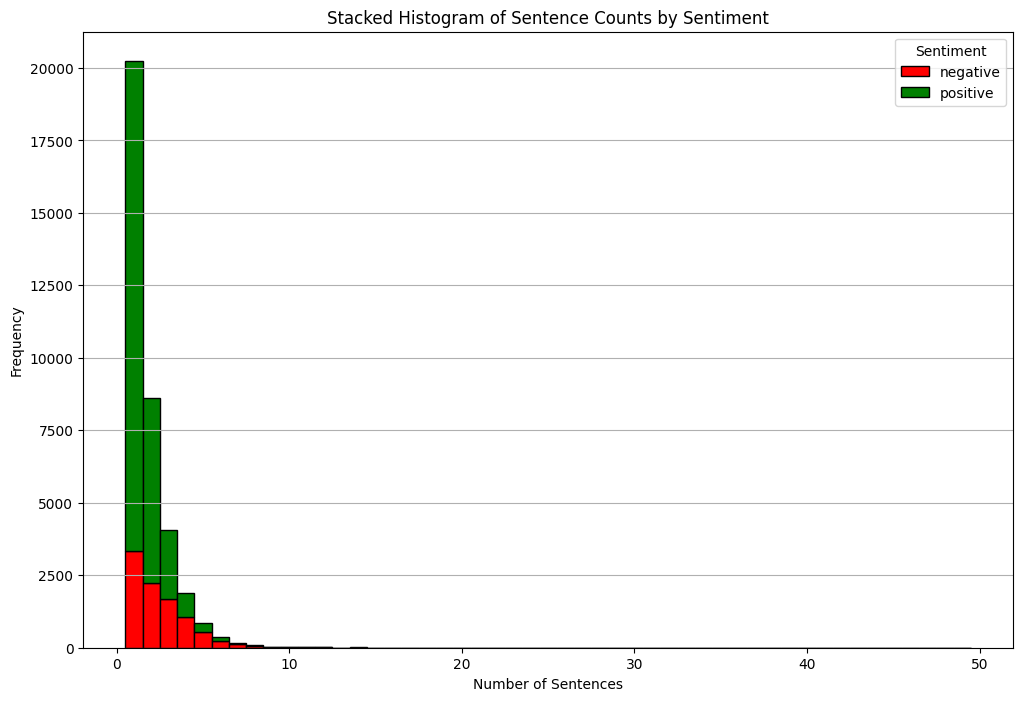

In [4]:
import re
import matplotlib.pyplot as plt

# Function to count the number of sentences
def count_sentences(text):
    if not isinstance(text, str):  # Check if the input is a string
        text = ''  # Treat non-strings (e.g., floats) as empty text
    sentences = re.split(r'[.!?]', text)
    # Filter out empty strings from splitting
    return len([s for s in sentences if s.strip()])

# Apply the function to count sentences for each record
unique_df['sentence_count'] = unique_df['text'].apply(count_sentences)

# Define colors for Sentiment
colors = {'negative': 'red', 'positive': 'green'}

# Create bins
bins = np.arange(1, unique_df['sentence_count'].max() + 2) - 0.5  # Center bins on integer values
bin_centers = (bins[:-1] + bins[1:]) / 2  # For placing the labels in the center

# Initialize the figure
plt.figure(figsize=(12, 8))

# Plot histogram for each sentiment
bottoms = np.zeros(len(bins) - 1)  # Initialize bottoms to zero for stacking

for sentiment, color in colors.items():
    subset = unique_df[unique_df['sentiment'] == sentiment]
    hist, _ = np.histogram(subset['sentence_count'], bins=bins)
    plt.bar(bin_centers, hist, width=1, color=color, edgecolor='black', label=sentiment, align='center', bottom=bottoms)
    bottoms += hist  # Update the bottoms for stacking

plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Sentence Counts by Sentiment')
plt.legend(title='Sentiment')
plt.grid(axis='y')
plt.show()

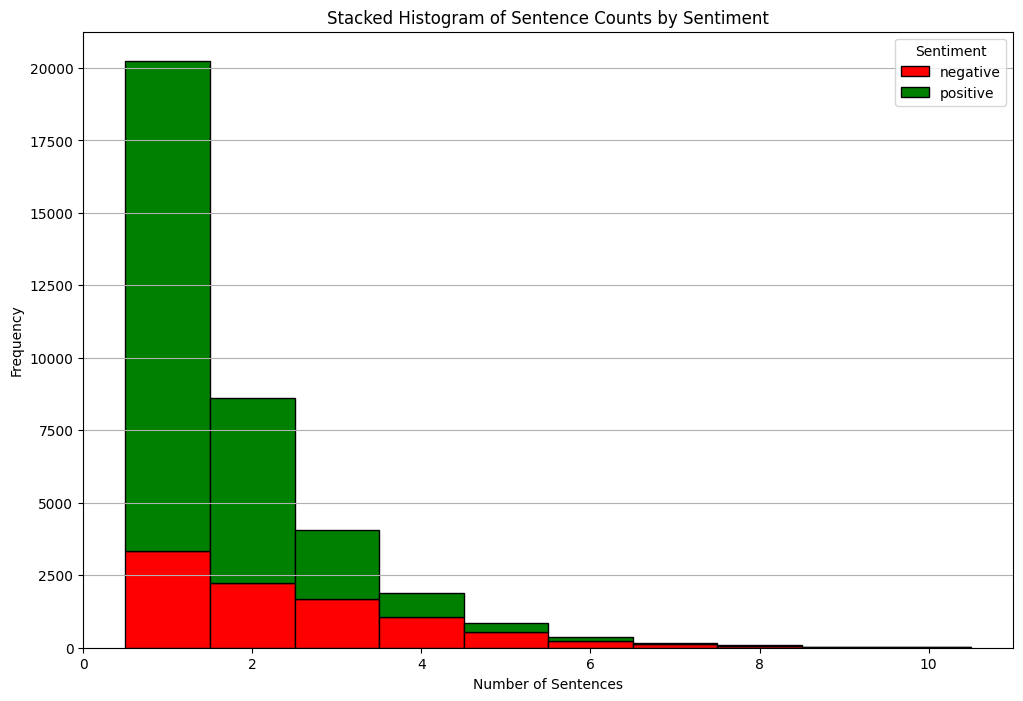

In [5]:
# Condition: Filter only reviews where no. of sentence <= 1
n = 10
filtered_df = unique_df[unique_df['sentence_count'] <= n]

# Define colors for Sentiment
colors = {'negative': 'red', 'positive': 'green'}

# Create bins
bins = np.arange(1, filtered_df['sentence_count'].max() + 2) - 0.5  # Center bins on integer values
bin_centers = (bins[:-1] + bins[1:]) / 2  # For placing the labels in the center

# Initialize the figure
plt.figure(figsize=(12, 8))

# Plot histogram for each sentiment
bottoms = np.zeros(len(bins) - 1)  # Initialize bottoms to zero for stacking

for sentiment, color in colors.items():
    subset = filtered_df[filtered_df['sentiment'] == sentiment]
    hist, _ = np.histogram(subset['sentence_count'], bins=bins)
    plt.bar(bin_centers, hist, width=1, color=color, edgecolor='black', label=sentiment, align='center', bottom=bottoms)
    bottoms += hist  # Update the bottoms for stacking

plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Sentence Counts by Sentiment')
plt.legend(title='Sentiment')
plt.grid(axis='y')
plt.show()

In [6]:
# Aspect-Based Sentiment Analysis (ABSA) ZeroShot
# No Fine-Tuning: Uses pre-trained models without specific training on target data
# Generalization: Leverages knowledge from diverse training to analyze unseen text
# Data Efficiency: Useful when labeled aspect data is limited or unavailable

from transformers import pipeline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# load the pipeline
sa = pipeline("sentiment-analysis")         # pipeline for Sentiment Analysis (SA)
qa = pipeline("question-answering")         # pipeline for Extractive Question-Answering (QA)
nli = pipeline("zero-shot-classification")  # pipeline for Zero-Shot Classification w NLI (NLI), better to identify keywords for candidate_labels

# text = "This movie was absolutely amazing!"
text = combined_df['Combined Text'][5]

print(text)
print(sa(text))
print(qa(question="What is this comment about?", context=text))
print(nli(text, candidate_labels=["positive comment", "negative comment", "neutral comment"]))

c:\Users\royle\OneDrive\Desktop\PLP Sem\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without

think ink think quality ink always keep spare hand
[{'label': 'NEGATIVE', 'score': 0.8906101584434509}]
{'score': 0.3680999279022217, 'start': 16, 'end': 50, 'answer': 'quality ink always keep spare hand'}
{'sequence': 'think ink think quality ink always keep spare hand', 'labels': ['positive comment', 'neutral comment', 'negative comment'], 'scores': [0.9157177209854126, 0.04764546453952789, 0.036636777222156525]}


In [11]:
reviews_df = combined_df[['Survey ID', 'Combined Text']].dropna().drop_duplicates()
reviews_df = reviews_df.drop_duplicates().reset_index()
reviews = reviews_df['Combined Text'].head(50)

In [8]:
# reviews = combined_df['Combined Text'].dropna().head(50)
# reviews

0                                         product great
1            item black cartridge divert time work fine
2                                  text easy understand
3     service excellent ink cartridge arrive next da...
4                             easy understand way write
5     think ink think quality ink always keep spare ...
6     think ink think quality ink always keep spare ...
7                                         great product
8     happy ink disappoint able use smart tank 650 p...
9     happy ink disappoint able use smart tank 650 p...
10                                                  use
11    nt subscribe ink monthly quarterly rate nt use...
12                                           rich color
13    print document ink cartridge fade smear resist...
18                                  super expensive job
19                advertise black ink come clear smudge
20                                                 work
21                                              

In [12]:
# Multi-turn Zero-shot ABSA on 
# 50 rows -> ~1min

import nltk
from nltk.tokenize import sent_tokenize
# nltk.download('punkt')

# Define categories
cats = ["printer", "ink", "service", "delivery", "general"]

# Initialize result list and sentence count
results = []
scount = 0

# Process each review
for r in reviews:
    scount += 1
    s = r  # Since each review is already one sentence, no need for tokenization
    labels = []

    # Find applicable categories
    for c in cats:
        yes = f"It's a comment on {c}"
        no = f"It's not a comment on {c}"
        res = nli(s, candidate_labels=[yes, no])
        label = res['labels'][0]
        if res['scores'][0] >= 0.9 and "not" not in label:
            labels.append(c)

    # If no specific category is detected, assign "general"
    if not labels:
        labels.append('general')

    # Determine the polarity for each detected category
    for l in labels:
        if l == "general":
            pos = "This is a positive comment in general"
            neg = "This is a negative comment in general"
            neu = "This is a neutral comment in general"
        else:
            pos = f"This is a positive comment on {l}"
            neg = f"This is a negative comment on {l}"
            neu = f"This is a neutral comment on {l}"

        # Determine sentiment using zero-shot classification
        res2 = nli(s, candidate_labels=[pos, neg, neu])
        polarity = res2['labels'][0]
        results.append({
            "sentence": s,
            "cat": l,
            "polarity": polarity[10:13],  # Extract polarity label
            "polarity_score": res2['scores'][0]
        })

print(f"Processed {scount} sentences.")

Processed 50 sentences.


In [19]:
df_results = pd.DataFrame(results)
summary = pd.crosstab(df_results['cat'], df_results['polarity'])

df_summary = pd.DataFrame(summary)
df_summary["category"] = df_summary.index
df_summary["total"] = df_summary["pos"]+df_summary["neg"]+df_summary["neu"]
# represent overall sentiment for the categary based on num of pos/neg
df_summary["sentiment"] = np.round((df_summary["pos"]-df_summary["neg"])/(df_summary["neg"]+df_summary["pos"]),2)

df_results
df_summary

polarity,neg,neu,pos,category,total,sentiment
cat,,,,,,
delivery,0,0,9,delivery,9,1.00
general,4,5,11,general,20,0.47
ink,6,0,14,ink,20,0.40
printer,8,1,15,printer,24,0.30
service,4,1,15,service,20,0.58


Text(0.5, 1.0, 'Sentiment Heat Map of Combined Review Aspects')

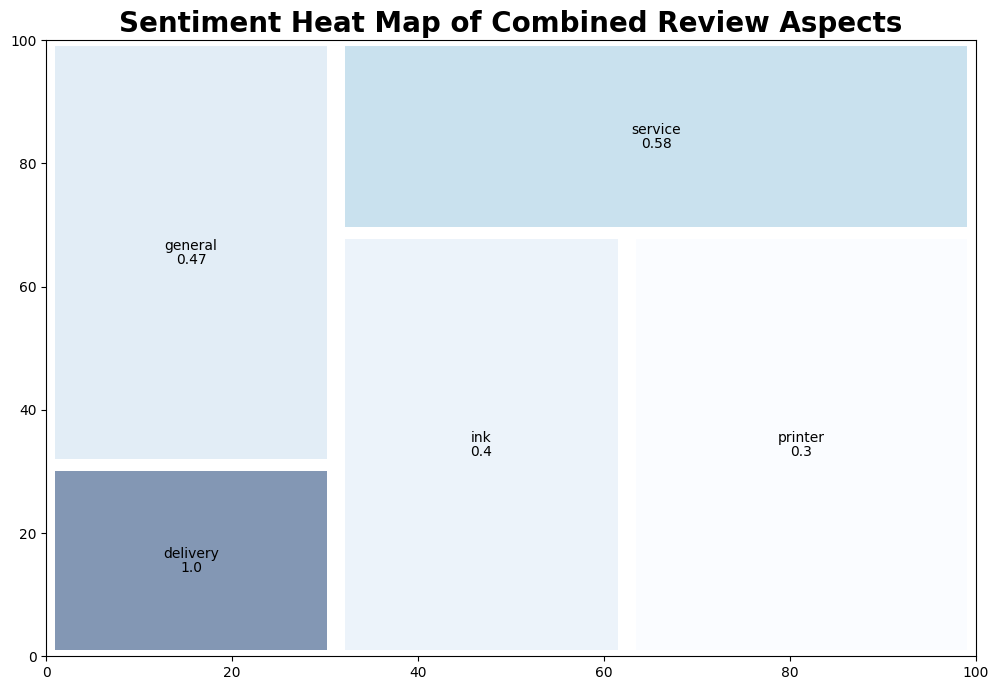

In [22]:
import squarify
import matplotlib
import matplotlib.pyplot as plt

norm = matplotlib.colors.Normalize(vmin=min(df_summary.sentiment), vmax=max(df_summary.sentiment))
colors = [matplotlib.cm.Blues(norm(value)) for value in df_summary.sentiment]

fig = plt.gcf()
fig.set_size_inches(12, 8)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
# Also used color intensity to reflect the sentiment value.
squarify.plot(label=df_summary.category,sizes=df_summary.total, value = df_summary.sentiment,color = colors, alpha=.5, pad =True)
plt.title("Sentiment Heat Map of Combined Review Aspects",fontsize=20,fontweight="bold")